In [94]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.optim as optim
from IPython import display
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

# Task 1: Read Dataset and Create Dataloaders

In [95]:
# transform =transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trans = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

train_set = torchvision.datasets.CIFAR10(root = './data', train=True, transform=trans,download=True)

# train_iterator
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle=True)

test_set = torchvision.datasets.CIFAR10(root = './data', train=False, transform=trans,download=True)

# test_itrator
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)

# GEtting GPU Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on {device} Deivce")

Files already downloaded and verified
Files already downloaded and verified
Running on cuda:0 Deivce


# The Block

In [96]:
class Block(torch.nn.Module):
    def __init__(self, k, input_channel, output_channel):
        super(Block, self).__init__()
        self.k = k
        self.Linear = nn.Linear(input_channel*8*8, self.k)
        nn.init.kaiming_uniform_(self.Linear.weight, mode='fan_in', nonlinearity='relu')
        self.softmax = nn.Softmax()
        self.avgpooling = nn.AdaptiveAvgPool2d(8)
        self.relu = nn.ReLU()
        self.Convl1 = nn.Conv2d(input_channel, output_channel, kernel_size = 3, padding = 1, stride = 1)
        
#         self.avgpooling = nn.BatchNorm2d(inputChannel)
#         self.avgpooling = nn.AvgPool2d(kernel_size=32, stride=1)

    def forward(self, x):
        
      # Spatial Average Pooling on Input
      pooling = self.avgpooling(x)
        
      # Flattning
      flatten_data = torch.flatten(pooling, start_dim=1)
        
      # Linear layer for each block
      linearOut = self.Linear(flatten_data)
        
      # Softmax function used as a Activation function on Linear layer output weights
      linear_out_after_activation = self.softmax(linearOut)
        
      # RELU
      # linearRelU = self.relu(linearOut)
        
      # Convolutional  Layer
      conv_out = self.Convl1(x)
        
      block_output = []
    
      # Performing Multiplication
      for i in range(self.k):
        a = linear_out_after_activation[0][i]
        block_output.append(a * conv_out)

      final_block_out = torch.sum(torch.stack(block_output), dim=0)
      return self.relu(final_block_out)
      

# BackBone and Classifier

In [97]:
class Backbone(nn.Module):
    def __init__(self, k, conv_arch, hidden_size, num_classes):
        super(Backbone, self).__init__()
        self.conv_arch = conv_arch
        #For RGB image input
        input_channel = 3
        
        # Backbone
        for i, output_channel in enumerate(conv_arch):
          self.add_module('Block{0}'.format(i), Block(k, input_channel, output_channel))
          input_channel = output_channel

        # Classifier
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(8), nn.Flatten(), nn.Linear(output_channel*8*8, hidden_size), 
                                  nn.ReLU(), nn.Dropout(0.6), nn.Linear(hidden_size, hidden_size), 
                                  nn.ReLU(), nn.Dropout(0.6), nn.Linear(hidden_size, num_classes))
        
        # Initializing neural network parameters using He initialization.
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
        
    def forward(self, x):
      out = x
      for i in range(len(self.conv_arch)):
        out = self._modules['Block{0}'.format(i)](out)
      final_output = self.classifier(out)
      return final_output

In [98]:
        # self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(inputChannel, outputchannel))
        # self.classifier = nn.Sequential(nn.Linear(outputchannel, 128),
        #                           nn.ReLU(), nn.Dropout(0.5), nn.Linear(128, 10))
        # self.classifier = nn.Linear(numInputs, numOutputs)

# Model

In [99]:
class CIFAR10Model(nn.Module):
    def __init__(self, k, conv_arch, hidden_size, num_classes):
        super(CIFAR10Model, self).__init__()
        self.backbone = Backbone(k, conv_arch, hidden_size, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x

# Model Architecture

In [100]:
conv_arch = (64, 128, 256, 512)
# conv_arch = (20, 40, 120)
num_classes = 10
k = 3
hidden_size = 4096

# Hyper-Parameters

In [101]:
model = CIFAR10Model(k, conv_arch, hidden_size, num_classes).to(device)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()

# optimizer = optim.AdamW(model.parameters(), lr=0.01)
# optimizer = optim.Adagrad(model.parameters(), lr=0.01)

optimizer = optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=0.01
)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training Model

In [102]:
# # Train the model
num_epochs = 30
total_loss_for_each_epoch = {}
total_accuracy_for_each_epoch = {}
for epoch in range(num_epochs):
    tr_loss = 0.0 
    tr_acc = 0.0
    tr_total = 0
    tr_correct = 0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        
        # Compute training accuracy
        val, predicted = outputs.max(1)
        tr_total += labels.size(0)
        tr_correct += predicted.eq(labels).sum().item()
        
    scheduler.step()
    
    # Print training progress
    avg_train_loss = tr_loss / len(train_loader)
    final_train_acc = 100 * tr_correct / tr_total
    print(f'Epoch {epoch+1}/{num_epochs}, \nTraining Loss: {avg_train_loss:.2f}, Training Accuracy: {final_train_acc:.2f}')

    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
          
            # Calculating test accuracy
            val, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

            # Compute and report the average test loss and test accuracy
            avg_test_loss = test_loss / len(test_loader)
            final_test_acc = 100 *( test_correct / test_total)

    total_loss_for_each_epoch[epoch+1] = [avg_train_loss, avg_test_loss]
    total_accuracy_for_each_epoch[epoch+1] = [final_train_acc, final_test_acc]

    print(f'Validation Loss: {avg_test_loss:.4f}, Validation Accuracy: {final_test_acc:.2f}%',end='\n\n')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/30, 
Training Loss: 1.63, Training Accuracy: 40.54
Validation Loss: 1.2244, Validation Accuracy: 55.23%

Epoch 2/30, 
Training Loss: 1.14, Training Accuracy: 59.67
Validation Loss: 0.9364, Validation Accuracy: 66.67%

Epoch 3/30, 
Training Loss: 0.92, Training Accuracy: 67.37
Validation Loss: 0.8697, Validation Accuracy: 70.09%

Epoch 4/30, 
Training Loss: 0.80, Training Accuracy: 71.82
Validation Loss: 0.7602, Validation Accuracy: 73.97%

Epoch 5/30, 
Training Loss: 0.71, Training Accuracy: 75.15
Validation Loss: 0.6872, Validation Accuracy: 75.96%

Epoch 6/30, 
Training Loss: 0.64, Training Accuracy: 78.09
Validation Loss: 0.6441, Validation Accuracy: 77.71%

Epoch 7/30, 
Training Loss: 0.57, Training Accuracy: 80.24
Validation Loss: 0.6298, Validation Accuracy: 78.56%

Epoch 8/30, 
Training Loss: 0.51, Training Accuracy: 82.13
Validation Loss: 0.6204, Validation Accuracy: 78.62%

Epoch 9/30, 
Training Loss: 0.46, Training Accuracy: 83.95
Validation Loss: 0.5913, Validation A

# Evaluation of Loss

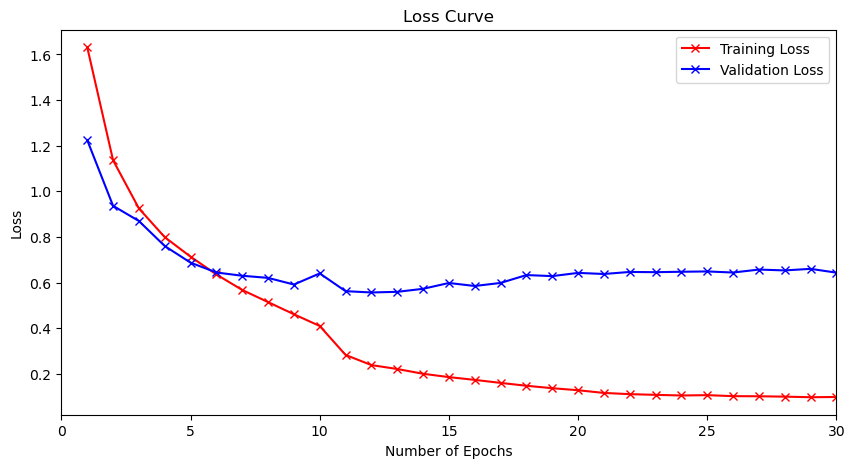

In [103]:
plt.figure(figsize = (10,5))
plt.xlim(0, 30)
plt.title("Loss Curve")
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
train_loss = [val[0] for val in total_loss_for_each_epoch.values()]
test_loss = [val[1] for val in total_loss_for_each_epoch.values()]

epoch = list(total_loss_for_each_epoch.keys())

plt.plot(epoch, train_loss, '-rx', label="Training Loss")
plt.plot(epoch, test_loss, '-bx', label="Validation Loss")
plt.legend(prop={'size': 10})
plt.show()

# Evaluation of Training and Validation Accuracy

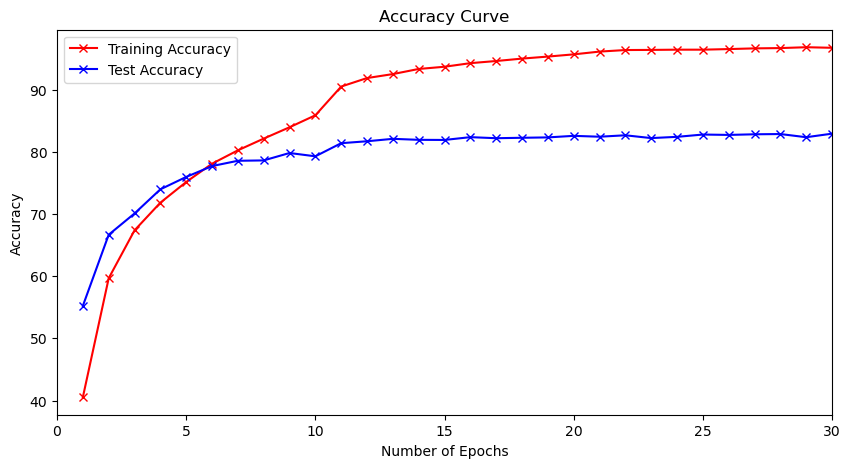

In [104]:
plt.figure(figsize = (10,5))
plt.xlim(0, 30)
plt.title("Accuracy Curve")
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
train_accuracies = [val[0] for val in total_accuracy_for_each_epoch.values()]
test_accuracies = [val[1] for val in total_accuracy_for_each_epoch.values()]

epoch = list(total_loss_for_each_epoch.keys())

plt.plot(epoch, train_accuracies, '-rx', label="Training Accuracy")
plt.plot(epoch, test_accuracies, '-bx', label="Test Accuracy")
plt.legend(prop={'size': 10})
plt.show()

# Test Accuracy

In [105]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute test accuracy
        val, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

# Computing average test loss and test accuracy
test_accuracy = 100 * test_correct / test_total
print(f'Final Model Test Accuracy: {test_accuracy:.2f}%')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Final Model Test Accuracy: 82.84%
